In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cifar10_input
import math

In [2]:
batch_size = 128
X_train, y_train = cifar10_input.distorted_inputs(batch_size=batch_size)
X_test, y_test = cifar10_input.inputs(eval_data=True, batch_size=batch_size)

In [3]:
def variable_with_weight_loss(shape, stddev, wl=None):
    var = tf.Variable(tf.truncated_normal(shape, stddev=stddev))
    if wl is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var), wl, name='weight_loss')
        tf.add_to_collection('losses', weight_loss)
    return var

def graph(image_holder, label_holder, global_step):
    weight1 = variable_with_weight_loss([5,5,3,64], stddev=5e-2)
    kernel1 = tf.nn.conv2d(image_holder, weight1, [1,1,1,1], padding='SAME')
    bias1 = tf.Variable(tf.constant(0.0, shape=[64]))
    conv1 = tf.nn.relu(kernel1+bias1)
    pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

    weight2 = variable_with_weight_loss([5,5,64,64], stddev=5e-2)
    kernel2 = tf.nn.conv2d(norm1, weight2, [1,1,1,1], padding='SAME')
    bias2 = tf.Variable(tf.constant(0.1,shape=[64]))
    conv2 = tf.nn.relu(kernel2+bias2)
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    pool2 = tf.nn.max_pool(norm2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    
    pool2_flat = tf.reshape(pool2, [-1,6*6*64])
    weight3 = variable_with_weight_loss(shape=[6*6*64, 384], stddev=0.04, wl=0.004)
    bias3 = tf.Variable(tf.constant(0.1, shape=[384]))
    fc1 = tf.nn.relu(tf.matmul(pool2_flat, weight3)+bias3)

    weight4 = variable_with_weight_loss(shape=[384, 192], stddev=0.04, wl=0.004)
    bias4 = tf.Variable(tf.constant(0.1, shape=[192]))
    fc2 = tf.nn.relu(tf.matmul(fc1, weight4)+bias4)

    weight5 = variable_with_weight_loss(shape=[192, 10], stddev=1/192.0)
    bias5 = tf.Variable(tf.constant(0.0, shape=[10]))
    logits = tf.matmul(fc2, weight5) + bias5
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf.one_hot(label_holder,depth=10))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    tf.add_to_collection('losses', cross_entropy_mean)
    loss = tf.add_n(tf.get_collection('losses'))
    
    correct_list = tf.equal(tf.argmax(logits, 1), label_holder)
    accuracy = tf.reduce_mean(tf.cast(correct_list, tf.float32))
    learning_rate = tf.train.exponential_decay(learning_rate=1e-3, global_step=global_step, decay_steps=1000, \
                                               decay_rate=0.95, staircase=True)
    backprop = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    return loss, accuracy, backprop

def training(sess, iteration=100, print_every=10, plot=True):
    cost_list = []
    val_acc_list = []
    acc_list = []
    for i in range(iteration):
        X_batch, y_batch = sess.run([X_train, y_train])
        cost, batch_acc, _ = sess.run([loss, accuracy, backprop], feed_dict={image_holder:X_batch, label_holder:y_batch})
        if i%print_every==0:
            cost_list.append(cost)
            acc_list.append(batch_acc)
            print('Iter: %d'%i,'Cost: %.3f'%cost,'Batch_acc: %.3f'%batch_acc)
            val_acc = test(sess)
            val_acc_list.append(val_acc)
    return cost_list, val_acc_list, acc_list

def test(sess):
    iteration_size = int(10000.0/batch_size)
    test_acc = 0.0
    for i in range(iteration_size):
        X_batch, y_batch = sess.run([X_test, y_test])
        acc = sess.run(accuracy, feed_dict={image_holder:X_batch, label_holder:y_batch})
        test_acc += acc
    test_acc /= iteration_size
    if 10000 % batch_size != 0:
        sess.run([X_test, y_test])
    print('Val acc: %.3f'%test_acc)
    return acc
        
image_holder = tf.placeholder(tf.float32, [None, 24, 24, 3])
label_holder = tf.placeholder(tf.int64, [None])
global_step = tf.Variable(0, trainable=False)
loss, accuracy, backprop = graph(image_holder, label_holder, global_step)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



W0606 16:07:01.542420 16856 tf_logging.py:125] From <ipython-input-3-0e3f55034fce>:36: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
cost_list, val_acc_list, acc_list = training(sess, iteration=int(50000/batch_size)*256, print_every=100)

Iter: 0 Cost: 4.681 Batch_acc: 0.102
Val acc: 0.153
Iter: 100 Cost: 1.861 Batch_acc: 0.352
Val acc: 0.372
Iter: 200 Cost: 1.670 Batch_acc: 0.430
Val acc: 0.472
Iter: 300 Cost: 1.605 Batch_acc: 0.492
Val acc: 0.498
Iter: 400 Cost: 1.474 Batch_acc: 0.508
Val acc: 0.531
Iter: 500 Cost: 1.361 Batch_acc: 0.492
Val acc: 0.573
Iter: 600 Cost: 1.387 Batch_acc: 0.555
Val acc: 0.599
Iter: 700 Cost: 1.324 Batch_acc: 0.578
Val acc: 0.602
Iter: 800 Cost: 1.308 Batch_acc: 0.578
Val acc: 0.617
Iter: 900 Cost: 1.434 Batch_acc: 0.500
Val acc: 0.591
Iter: 1000 Cost: 1.298 Batch_acc: 0.578
Val acc: 0.638
Iter: 1100 Cost: 1.455 Batch_acc: 0.516
Val acc: 0.633
Iter: 1200 Cost: 1.385 Batch_acc: 0.586
Val acc: 0.627
Iter: 1300 Cost: 1.136 Batch_acc: 0.695
Val acc: 0.646
Iter: 1400 Cost: 1.096 Batch_acc: 0.688
Val acc: 0.662
Iter: 1500 Cost: 1.342 Batch_acc: 0.531
Val acc: 0.670
Iter: 1600 Cost: 1.052 Batch_acc: 0.727
Val acc: 0.661
Iter: 1700 Cost: 1.378 Batch_acc: 0.633
Val acc: 0.679
Iter: 1800 Cost: 1.178

Iter: 14800 Cost: 0.699 Batch_acc: 0.797
Val acc: 0.816
Iter: 14900 Cost: 0.718 Batch_acc: 0.750
Val acc: 0.818
Iter: 15000 Cost: 0.996 Batch_acc: 0.664
Val acc: 0.820
Iter: 15100 Cost: 0.690 Batch_acc: 0.828
Val acc: 0.838
Iter: 15200 Cost: 0.749 Batch_acc: 0.773
Val acc: 0.837
Iter: 15300 Cost: 0.702 Batch_acc: 0.758
Val acc: 0.825
Iter: 15400 Cost: 0.576 Batch_acc: 0.852
Val acc: 0.830
Iter: 15500 Cost: 0.737 Batch_acc: 0.773
Val acc: 0.825
Iter: 15600 Cost: 0.665 Batch_acc: 0.797
Val acc: 0.835
Iter: 15700 Cost: 0.675 Batch_acc: 0.789
Val acc: 0.832
Iter: 15800 Cost: 0.596 Batch_acc: 0.820
Val acc: 0.831
Iter: 15900 Cost: 0.904 Batch_acc: 0.719
Val acc: 0.819
Iter: 16000 Cost: 0.578 Batch_acc: 0.836
Val acc: 0.832
Iter: 16100 Cost: 0.695 Batch_acc: 0.789
Val acc: 0.831
Iter: 16200 Cost: 0.804 Batch_acc: 0.758
Val acc: 0.829
Iter: 16300 Cost: 0.678 Batch_acc: 0.820
Val acc: 0.824
Iter: 16400 Cost: 0.727 Batch_acc: 0.750
Val acc: 0.831
Iter: 16500 Cost: 0.739 Batch_acc: 0.742
Val acc

Iter: 29400 Cost: 0.547 Batch_acc: 0.836
Val acc: 0.862
Iter: 29500 Cost: 0.645 Batch_acc: 0.789
Val acc: 0.860
Iter: 29600 Cost: 0.505 Batch_acc: 0.820
Val acc: 0.865
Iter: 29700 Cost: 0.476 Batch_acc: 0.859
Val acc: 0.857
Iter: 29800 Cost: 0.490 Batch_acc: 0.859
Val acc: 0.856
Iter: 29900 Cost: 0.577 Batch_acc: 0.805
Val acc: 0.866
Iter: 30000 Cost: 0.593 Batch_acc: 0.797
Val acc: 0.866
Iter: 30100 Cost: 0.637 Batch_acc: 0.820
Val acc: 0.875
Iter: 30200 Cost: 0.544 Batch_acc: 0.789
Val acc: 0.869
Iter: 30300 Cost: 0.554 Batch_acc: 0.828
Val acc: 0.865
Iter: 30400 Cost: 0.614 Batch_acc: 0.828
Val acc: 0.865
Iter: 30500 Cost: 0.466 Batch_acc: 0.898
Val acc: 0.869
Iter: 30600 Cost: 0.589 Batch_acc: 0.836
Val acc: 0.868
Iter: 30700 Cost: 0.600 Batch_acc: 0.820
Val acc: 0.865
Iter: 30800 Cost: 0.524 Batch_acc: 0.852
Val acc: 0.863
Iter: 30900 Cost: 0.542 Batch_acc: 0.812
Val acc: 0.863
Iter: 31000 Cost: 0.649 Batch_acc: 0.812
Val acc: 0.871
Iter: 31100 Cost: 0.546 Batch_acc: 0.812
Val acc

Iter: 44000 Cost: 0.585 Batch_acc: 0.805
Val acc: 0.888
Iter: 44100 Cost: 0.520 Batch_acc: 0.836
Val acc: 0.880
Iter: 44200 Cost: 0.467 Batch_acc: 0.875
Val acc: 0.884
Iter: 44300 Cost: 0.592 Batch_acc: 0.797
Val acc: 0.881
Iter: 44400 Cost: 0.510 Batch_acc: 0.828
Val acc: 0.884
Iter: 44500 Cost: 0.453 Batch_acc: 0.875
Val acc: 0.888
Iter: 44600 Cost: 0.614 Batch_acc: 0.844
Val acc: 0.879
Iter: 44700 Cost: 0.498 Batch_acc: 0.844
Val acc: 0.888
Iter: 44800 Cost: 0.445 Batch_acc: 0.891
Val acc: 0.891
Iter: 44900 Cost: 0.620 Batch_acc: 0.805
Val acc: 0.891
Iter: 45000 Cost: 0.617 Batch_acc: 0.805
Val acc: 0.892
Iter: 45100 Cost: 0.517 Batch_acc: 0.828
Val acc: 0.886
Iter: 45200 Cost: 0.517 Batch_acc: 0.812
Val acc: 0.886
Iter: 45300 Cost: 0.430 Batch_acc: 0.867
Val acc: 0.891
Iter: 45400 Cost: 0.418 Batch_acc: 0.875
Val acc: 0.882
Iter: 45500 Cost: 0.482 Batch_acc: 0.812
Val acc: 0.889
Iter: 45600 Cost: 0.475 Batch_acc: 0.859
Val acc: 0.883
Iter: 45700 Cost: 0.536 Batch_acc: 0.812
Val acc

Iter: 58600 Cost: 0.485 Batch_acc: 0.898
Val acc: 0.904
Iter: 58700 Cost: 0.408 Batch_acc: 0.891
Val acc: 0.897
Iter: 58800 Cost: 0.433 Batch_acc: 0.859
Val acc: 0.900
Iter: 58900 Cost: 0.544 Batch_acc: 0.820
Val acc: 0.898
Iter: 59000 Cost: 0.548 Batch_acc: 0.852
Val acc: 0.899
Iter: 59100 Cost: 0.644 Batch_acc: 0.805
Val acc: 0.903
Iter: 59200 Cost: 0.443 Batch_acc: 0.828
Val acc: 0.896
Iter: 59300 Cost: 0.465 Batch_acc: 0.836
Val acc: 0.898
Iter: 59400 Cost: 0.612 Batch_acc: 0.797
Val acc: 0.894
Iter: 59500 Cost: 0.380 Batch_acc: 0.883
Val acc: 0.896
Iter: 59600 Cost: 0.449 Batch_acc: 0.828
Val acc: 0.901
Iter: 59700 Cost: 0.424 Batch_acc: 0.859
Val acc: 0.897
Iter: 59800 Cost: 0.430 Batch_acc: 0.875
Val acc: 0.902
Iter: 59900 Cost: 0.411 Batch_acc: 0.898
Val acc: 0.902
Iter: 60000 Cost: 0.495 Batch_acc: 0.820
Val acc: 0.899
Iter: 60100 Cost: 0.641 Batch_acc: 0.805
Val acc: 0.902
Iter: 60200 Cost: 0.500 Batch_acc: 0.859
Val acc: 0.896
Iter: 60300 Cost: 0.474 Batch_acc: 0.852
Val acc

Iter: 73200 Cost: 0.429 Batch_acc: 0.844
Val acc: 0.905
Iter: 73300 Cost: 0.427 Batch_acc: 0.844
Val acc: 0.904
Iter: 73400 Cost: 0.464 Batch_acc: 0.828
Val acc: 0.910
Iter: 73500 Cost: 0.464 Batch_acc: 0.852
Val acc: 0.904
Iter: 73600 Cost: 0.614 Batch_acc: 0.781
Val acc: 0.906
Iter: 73700 Cost: 0.556 Batch_acc: 0.812
Val acc: 0.901
Iter: 73800 Cost: 0.334 Batch_acc: 0.922
Val acc: 0.906
Iter: 73900 Cost: 0.399 Batch_acc: 0.867
Val acc: 0.906
Iter: 74000 Cost: 0.455 Batch_acc: 0.875
Val acc: 0.903
Iter: 74100 Cost: 0.451 Batch_acc: 0.867
Val acc: 0.907
Iter: 74200 Cost: 0.487 Batch_acc: 0.859
Val acc: 0.901
Iter: 74300 Cost: 0.410 Batch_acc: 0.859
Val acc: 0.904
Iter: 74400 Cost: 0.444 Batch_acc: 0.844
Val acc: 0.909
Iter: 74500 Cost: 0.354 Batch_acc: 0.914
Val acc: 0.905
Iter: 74600 Cost: 0.374 Batch_acc: 0.891
Val acc: 0.908
Iter: 74700 Cost: 0.488 Batch_acc: 0.828
Val acc: 0.905
Iter: 74800 Cost: 0.396 Batch_acc: 0.883
Val acc: 0.906
Iter: 74900 Cost: 0.487 Batch_acc: 0.828
Val acc

Iter: 87800 Cost: 0.429 Batch_acc: 0.859
Val acc: 0.912
Iter: 87900 Cost: 0.412 Batch_acc: 0.820
Val acc: 0.908
Iter: 88000 Cost: 0.372 Batch_acc: 0.883
Val acc: 0.909
Iter: 88100 Cost: 0.490 Batch_acc: 0.820
Val acc: 0.906
Iter: 88200 Cost: 0.357 Batch_acc: 0.906
Val acc: 0.910
Iter: 88300 Cost: 0.444 Batch_acc: 0.898
Val acc: 0.912
Iter: 88400 Cost: 0.411 Batch_acc: 0.859
Val acc: 0.907
Iter: 88500 Cost: 0.432 Batch_acc: 0.891
Val acc: 0.910
Iter: 88600 Cost: 0.322 Batch_acc: 0.922
Val acc: 0.904
Iter: 88700 Cost: 0.553 Batch_acc: 0.844
Val acc: 0.910
Iter: 88800 Cost: 0.451 Batch_acc: 0.852
Val acc: 0.913
Iter: 88900 Cost: 0.343 Batch_acc: 0.906
Val acc: 0.907
Iter: 89000 Cost: 0.499 Batch_acc: 0.852
Val acc: 0.910
Iter: 89100 Cost: 0.351 Batch_acc: 0.930
Val acc: 0.904
Iter: 89200 Cost: 0.610 Batch_acc: 0.859
Val acc: 0.907
Iter: 89300 Cost: 0.477 Batch_acc: 0.844
Val acc: 0.912
Iter: 89400 Cost: 0.501 Batch_acc: 0.867
Val acc: 0.909
Iter: 89500 Cost: 0.450 Batch_acc: 0.859
Val acc

Val acc: 0.908


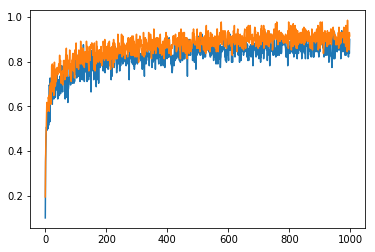

In [5]:
test(sess)
plt.plot(acc_list)
plt.plot(val_acc_list)
plt.show()

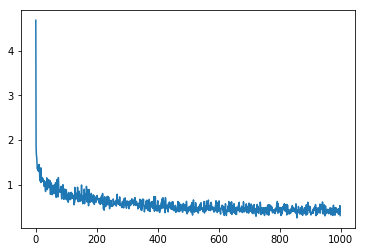

In [6]:
plt.plot(cost_list)
plt.show()